# Analysis and Impacts of Fake News

Everybody lies at some point of time. However, if the liar is a popular and respected source or figure in society, this may have crucial effects on people. The goal of this project is to analyze the distribution of lies among the political figures and news sources in the U.S. and the effects of these lies on voters and social media. We use Liar dataset collected from PolitiFact.com and prepared by William Yang Wang. We aim to specify the topics which politicians and news sources mostly lie about. Also, we intend to reveal if the lies told by politicians propagate to other news sources. We would like to emphasize the power of the statements made by notable sources in society. Because, we believe that the manipulation of people's decisions through fake news may have drastic effects on society and democracy in a country. As we are all from Turkey, we are the witnesses of how biased media manipulates the people's political views which determine the future of the country.

We use Liar dataset collected from PolitiFact.com and prepared by William Yang Wang. The dataset is in tsv format, and also for each row, there is an HTML link column including some additional information about the specific statement. We will parse the dataset as well as the webpage to extract other informations such as statement date and place. The dataset contains train, test and validation sets amd has nearly 12k statements. We will combine them for analysis.

***

## Part 1: Data Wrangling and Data Preprocessing

In [2]:
# Import libraries
%matplotlib inline
import requests
from bs4 import BeautifulSoup
from datetime import datetime
import csv
import pandas as pd
import numpy as np
from sklearn.externals import joblib
import multiprocessing as multi
import sys
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import nltk
import folium
import json
from scipy import stats

Our dataset is prepared for a automatic fake news detection project. Therefore we had train, test and validation datasets. In order to analyze our dataset we concatenated these three datasets.

In [3]:
with open('data/liar_dataset/valid.tsv') as tsvfile:
    valid = pd.read_csv(tsvfile,sep='\t')
    print("Validation Set Size: {}".format(len(valid)))

Validation Set Size: 1284


In [4]:
with open('data/liar_dataset/test.tsv') as tsvfile:
    test = pd.read_csv(tsvfile, sep='\t')
    print("Test Set Size: {}".format(len(test)))

Test Set Size: 1277


In [5]:
with open('data/liar_dataset/train.tsv') as tsvfile:
    train = pd.read_csv(tsvfile, sep='\t')
    print("Training Set Size: {}".format(len(train)))

Training Set Size: 10240


In [6]:
# Concatinating all training, test and validation sets to create a big dataset for analysis.
sets = [train, test, valid]
liar_dataframe = pd.concat(sets)
print("Number of samples:",len(liar_dataframe))
liar_dataframe.reset_index()
liar_dataframe.head()

Number of samples: 12801


,Id,Label,Statement,Subject,Speaker’s Job Title,Job,State,The Party Affiliation,barely true counts,false counts,half true counts,mostly true counts,pants on fire counts,Communication Media
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0,0.0,a mailer
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1,0.0,a floor speech.
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163,9.0,Denver
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5,44.0,a news release
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19,2.0,an interview on CNN


First column contains the id of the statement and the url http://www.politifact.com//api/v/2/statement/id?format=json links to the web page about the statement.

The given dataset does not contain the date when the statement is written or said. So, we parsed the web page in order the extract the statement date. All of the columns except counts columns can be understood. Counts columns show the number of the people that vote for that authenticity category for the particular statement.

In [188]:
# JSON parse code using Id column of the dataset

i=0
for json_id in liar_dataframe['Id']:
    try:
        r = requests.get('http://www.politifact.com//api/v/2/statement/'+ json_id.split(".")[0]+'/?format=json')
        data=r.json()
        datetime_object = datetime.strptime(data["ruling_date"], '%Y-%m-%dT%X')
        liar_dataframe.set_value(i, 'Date', datetime_object)
    except ValueError:
        print(json_id, "ENCODE ERROR OCCURED")
    i+=1

In [7]:
#liar_dataframe.to_csv('data/liar_set_with_date.tsv',index=False, sep = '\t')

In [7]:
with open('data/liar_set_with_date.tsv') as tsvfile:
    liar_dataframe = pd.read_csv(tsvfile,sep='\t',)
len(liar_dataframe)
liar_dataframe.head()

,Id,Label,Statement,Subject,Speaker’s Job Title,Job,State,The Party Affiliation,barely true counts,false counts,half true counts,mostly true counts,pants on fire counts,Communication Media,Date
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer,2010-10-20 06:00:00
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,2015-02-23 00:00:00
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver,2008-02-01 00:00:00
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release,2009-08-07 12:13:20
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN,2014-03-11 15:57:54


There are some data rows with no **Date** information, since the url was not working for some of data. 

In [8]:
liar_dataframe = liar_dataframe[liar_dataframe['Date'].notnull()]

Since we will also analyse the effects of lies told by politicians and news sources on votes of citizens(Research Question 4), we need the earliest and latest date, so that we find out which US election resulys will be needed.

In [9]:
max(liar_dataframe['Date'])

'2016-12-13 05:00:00'

In [10]:
min(liar_dataframe['Date'])

'2007-05-02 00:00:00'

In order to answer our research questions, we need to know if the given statement is said by a politician, a news source or posted on social media. So we categorized the **Communication Media** column using the keywords inside.

In [11]:
# Categorizing Communication Media
def categorize(a):
    a['Category'] = ''
    exp = a['Communication Media'].str.lower().str
    condition_press = exp.contains('news ') | exp.contains('press ') |exp.contains(' news') | exp.contains(' press')
    
    condition_interview = exp.contains('interview')
    condition_speech = exp.contains('speech') | exp.contains('address ') | exp.contains(' address')
    condition_hearing = exp.contains('hearing')
    condition_meeting = exp.contains('meeting')
    condition_summit = exp.contains('summit')
    condition_letter = exp.contains('letter')
    condition_statement = exp.contains('statement')
    condition_social_media = exp.contains('twitter') | exp.contains('tweet') | exp.contains('facebook') \
                         | exp.contains('meme') | exp.contains('comments') | exp.contains('post') \
                         | exp.contains('blog') |  exp.contains('forum')
    condition_conference = exp.contains('conference')
    condition_advertisement = exp.contains('advertisement') | exp.contains('advert') \
                          | exp.contains(' ad') | exp.contains('commercial')
    condition_campaign = exp.contains('campaign')
    condition_newspaper = exp.contains('newspaper') | exp.contains('article') | exp.contains('column') \
                         | exp.contains('commentary') | exp.contains('op-ed') 
    condition_video = exp.contains('video')
    condition_radio = exp.contains('radio')
    condition_debate = exp.contains('debate')
    condition_flyer = exp.contains('flyer') | exp.contains('flier')
    condition_journal = exp.contains('journal')  
    condition_television = (exp.contains('television') | exp.contains('tv ') | \
                        exp.contains(' tv') | exp.contains('"') ) & (exp.contains('comments on')==False)
    a['Category'] = np.where(condition_press, a['Category']+',Press', a['Category']) 
    a['Category'] = np.where(condition_interview, a['Category']+',Interview', a['Category']) 
    a['Category'] = np.where(condition_speech, a['Category']+',Speech', a['Category']) 
    a['Category'] = np.where(condition_hearing, a['Category']+',Hearing', a['Category']) 
    a['Category'] = np.where(condition_meeting, a['Category']+',Meeting', a['Category']) 
    a['Category'] = np.where(condition_summit, a['Category']+',Summit', a['Category']) 
    a['Category'] = np.where(condition_letter, a['Category']+',Letter', a['Category']) 
    a['Category'] = np.where(condition_statement, a['Category']+',Statement', a['Category']) 
    a['Category'] = np.where(condition_social_media, a['Category']+',Social Media', a['Category']) 
    a['Category'] = np.where(condition_conference, a['Category']+',Conference', a['Category']) 
    a['Category'] = np.where(condition_advertisement, a['Category']+',Advertisement', a['Category']) 
    a['Category'] = np.where(condition_campaign, a['Category']+',Campaign', a['Category']) 
    a['Category'] = np.where(condition_newspaper, a['Category']+',Newspaper', a['Category']) 
    a['Category'] = np.where(condition_video, a['Category']+',Video', a['Category']) 
    a['Category'] = np.where(condition_debate, a['Category']+',Debate', a['Category']) 
    a['Category'] = np.where(condition_flyer, a['Category']+',Flyer', a['Category']) 
    a['Category'] = np.where(condition_radio, a['Category']+',Radio', a['Category']) 
    a['Category'] = np.where(condition_journal, a['Category']+',Journal', a['Category']) 
    a['Category'] = np.where(a['Category'] == '', a['Category']+',Miscellaneous', a['Category']) 
    a['Category'] = a['Category'].str[1:]
    return a

In [12]:
liar_dataframe = categorize(liar_dataframe)

In [13]:
liar_dataframe.head(3)

,Id,Label,Statement,Subject,Speaker’s Job Title,Job,State,The Party Affiliation,barely true counts,false counts,half true counts,mostly true counts,pants on fire counts,Communication Media,Date,Category
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer,2010-10-20 06:00:00,Miscellaneous
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,2015-02-23 00:00:00,Speech
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver,2008-02-01 00:00:00,Miscellaneous


Target column is **Label**. Authenticity types of the statements can be found by grouping the dataset by **Label** column.

In [14]:
data_group_df = liar_dataframe.groupby('Label')
data_group_df.groups.keys()

dict_keys(['barely-true', 'false', 'half-true', 'mostly-true', 'pants-fire', 'true'])

Some of our research questions require U.S. Election data. We preprocess the election data for 2012 and 2016 U.S. Elections.

United States Presidental elections held in every 4 years. United states use a system called **Electoral System** for electing their presidents. This system works as following:

- Each state is assigned a number of electors which is equal to the number of its U.S. Senators(2) plus the number of its U.S. Representatives. The number of US Representatives is determined according to state's population.
- Each pary assign its electors who will actually vote for presidental candidates.
- In November, citizens of each state cast their votes for electors, not for president.
- The party having the most popular vote in november election becımes the State's Electors.
- On the Monday following the second Wednesday of December each State's Electors cast their electoral votes for president and for vice president.

In [14]:
# Path to files of election results
ELECTION_PATH = "data/elections/federalelections"

In [15]:
# read votes and convert vote counts to percentage
def read_votes(year,file_type):
    votes = pd.read_excel(ELECTION_PATH+str(year)+'.'+file_type,sheet_name="Table 2. Electoral &  Pop Vote", header=3)
    votes.iloc[:,3]=(votes.iloc[:,3]/votes.iloc[:,6])*100 # percentage of vote ratio - democrats
    votes.iloc[:,4]=(votes.iloc[:,4]/votes.iloc[:,6])*100 # percentage of vote ratio - republicans
    return votes

Since ther earliest data is from 2007 and latest is from 2016, we need results of the presidental election in years 2008, 2012 and 2016 

In [16]:
votes_2008 = read_votes(2008,'xls')
votes_2012 = read_votes(2012,'xls')
votes_2016 = read_votes(2016,'xlsx')

We added **Winner** column: D represenst Democrat Party candidate and R represents Republican Party candidate.

In [649]:
votes_2008['Winner'] = votes_2008.iloc[:,3]>votes_2008.iloc[:,4]
votes_2008['Winner'] = np.where(votes_2008['Winner']==True,'D','R')

votes_2012['Winner'] = votes_2012.iloc[:,3]>votes_2012.iloc[:,4]
votes_2012['Winner'] = np.where(votes_2012['Winner']==True,'D','R')

votes_2016['Winner'] = votes_2016.iloc[:,3]>votes_2016.iloc[:,4]
votes_2016['Winner'] = np.where(votes_2016['Winner']==True,'D','R')

In [650]:
votes_2012.head(5)

,STATE,Obama (D),Romney (R),Obama (D).1,Romney (R).1,All Others,Total Vote,Winner
0,AL,NaN,9.0,38.359033,60.545822,22717,2074338,R
1,AK,NaN,3.0,40.812659,54.801577,13179,300495,R
2,AZ,NaN,11.0,44.589767,53.654533,40368,2299254,R
3,AR,NaN,6.0,36.878990,60.566936,27315,1069468,R
4,CA,55.0,NaN,60.238959,37.120379,344304,13038547,D


First two columns represent the electoral votes and the 3rd and 4th column represent popular votes.

In [651]:
vote_change = pd.DataFrame(columns=['STATE',\
                                    'Winner Change 2008-2012', 'Democrat 2008-2012', 'Republican 2008-2012',\
                                    'Winner Change 2012-2016','Democrat 2012-2016', 'Republican 2012-2016'])

In [652]:
vote_change['STATE'] = votes_2008['STATE']

We calculated the change of percentage of votes between years for democrat and republican candidates.

In [653]:
#change of winner 2004 and 2008(R, D, R to D, D to R)
vote_change['Winner Change 2008-2012'] = np.where(votes_2008['Winner']==votes_2012['Winner'],\
                                        votes_2008['Winner'],votes_2008['Winner']+' to '+votes_2012['Winner'])
#change in votes between years 2008 and 2012
vote_change['Democrat 2008-2012'] = votes_2012.iloc[:,3] - votes_2008.iloc[:,3]
vote_change['Republican 2008-2012'] = votes_2012.iloc[:,4] - votes_2008.iloc[:,4]

In [654]:
#change of winner 2004 and 2008(R, D, R to D, D to R)
vote_change['Winner Change 2012-2016'] = np.where(votes_2012['Winner']==votes_2016['Winner'],\
                                        votes_2012['Winner'],votes_2012['Winner']+' to '+votes_2016['Winner'])
#change in votes between years 2012 and 2016
vote_change['Democrat 2012-2016'] = votes_2016.iloc[:,3] - votes_2012.iloc[:,3]
vote_change['Republican 2012-2016'] = votes_2016.iloc[:,4] - votes_2012.iloc[:,4]

In [655]:
vote_change.head(5)

,STATE,Winner Change 2008-2012,Democrat 2008-2012,Republican 2008-2012,Winner Change 2012-2016,Democrat 2012-2016,Republican 2012-2016
0,AL,R,-0.381401,0.228909,R,-4.001087,1.537270
1,AK,R,2.923286,-4.622942,R,-4.261788,-3.520065
2,AZ,R,-0.525484,0.019285,R,0.536255,-4.982917
3,AR,R,-1.985669,1.851032,R,-3.227086,0.004970
4,CA,D,-0.773679,0.165520,D,1.487429,-5.503264


In Milestone 2, we have not performed any analysis using the change between years. However, we are planning to use that column in the next steps.

***

## Part 2: Exploratory data analysis 

We have created some research questions for the dataset in Milestone 1. We analyze the data based on these research questions in this part. The questions are:

### Q1. What are the subjects that the politicians and news sources mostly lie about?

We consider that a statement is a lie if it is labelled as false or pants-fire. We create the counts of subjects for each label category.

In [26]:
# Distribution of subjects of statements per each truth label category

# This function returns the count of unique elements for each output (i.e. false, pants-fire, barely-true) 
# with respect to the given column name.

def get_count_group(col_num, df, delimiter, get_all, n=0):
    result = []
    i = 0
    for group in df:
        col = group[1][col_num]
        if(len(delimiter) > 0):
            if(get_all):
                elements = pd.Series(str(v).split(delimiter) for v in col)
            else:
                elements = pd.Series(str(v).split(delimiter) for v in col)
            elements = [st for row in elements for st in row]
            element_values = pd.Series(elements).str.lower().str.rstrip('.,"”\'').str.lstrip('\'\"”').value_counts()
        else:
            elements = pd.Series(v for v in col)
            elements = [st for st in elements]
            element_values = pd.Series(elements).value_counts()
        result.append([])
        result[i].append(group[0])
        result[i].append(element_values)
        i = i + 1
    return result

We will get unique subjects for each output label. It will return 6 series object since we have 6 different outputs. We will get false and pants-fire statements to determine the counts of subjects in the lies.

In [16]:
# Get unique subjects for each target value.
statement_counts = get_count_group('Subject', data_group_df, ',', True)

In [17]:
# Get subject counts in false and pants-fire statements.
false_st = statement_counts[1]
pants_fire_st = statement_counts[4]

We show the top 20 subjects in the pants-fire statements.

In [18]:
print("Top 20 subjects in the pants-fire statements:\n{}".format(pants_fire_st[1][:20]))

Top 20 subjects in the pants-fire statements:
health-care             150
candidates-biography     95
taxes                    83
elections                75
economy                  73
immigration              66
history                  60
foreign-policy           58
state-budget             56
religion                 54
crime                    49
education                48
jobs                     45
federal-budget           43
terrorism                41
military                 37
environment              37
energy                   36
pundits                  34
message-machine-2012     34
dtype: int64


We show the top 20 subjects in false statements.

In [19]:
print("Top 20 subjects in false statements:\n{}".format(false_st[1][:20]))

Top 20 subjects in false statements:
health-care             331
economy                 239
taxes                   230
federal-budget          183
elections               173
state-budget            169
candidates-biography    166
jobs                    164
education               147
immigration             133
foreign-policy          119
history                 111
energy                  105
legal-issues             97
environment              92
crime                    91
terrorism                81
job-accomplishments      81
guns                     71
transportation           68
dtype: int64


We will combine both of them to create subjects in lie statements and we will show top 20 subjects in false and pants-fire statements.

In [20]:
# Combining both statement types and sum the counts
lie_subjects = pd.concat([false_st[1][:20], pants_fire_st[1][:20]])
lie_subjects = lie_subjects.groupby(lie_subjects.index).sum().sort_values(ascending=False)[:20]

In [21]:
import pylab
import sys

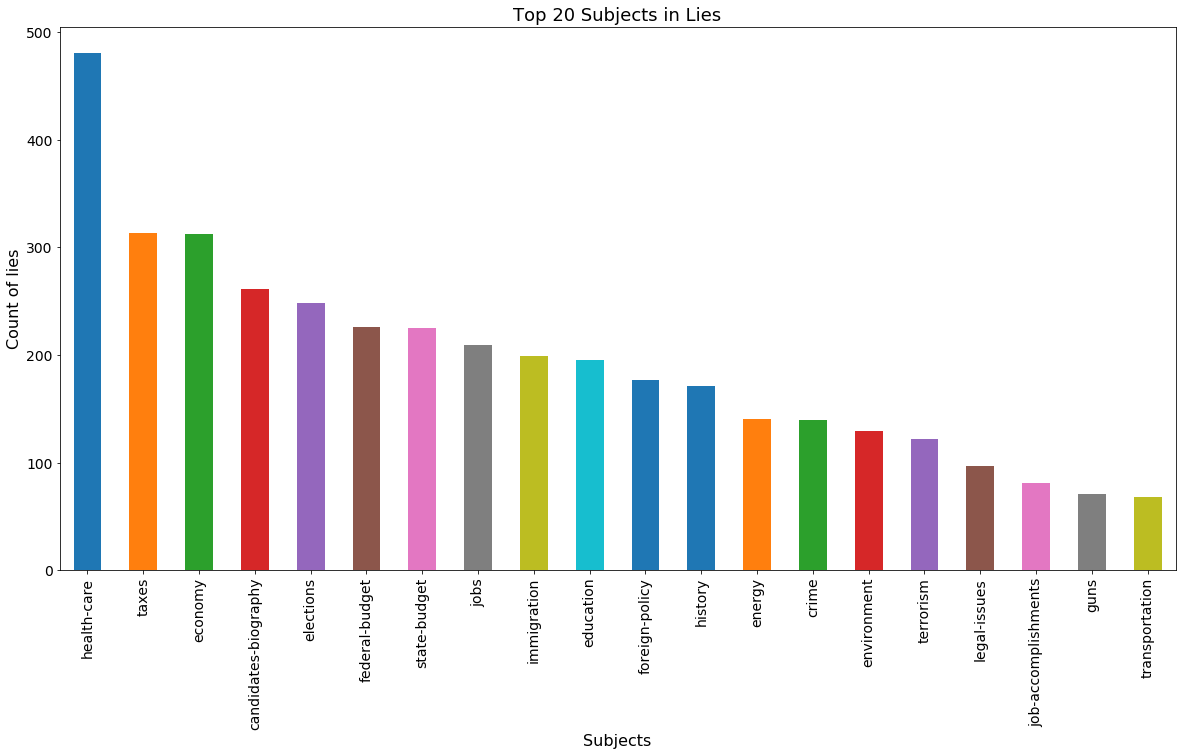

In [36]:
fig = plt.figure(figsize=(20,10))
lie_subjects.plot.bar()
plt.xlabel('Subjects', fontsize=16)
plt.ylabel('Count of lies', fontsize=16)
plt.title('Top 20 Subjects in Lies', fontsize=18)
plt.gca().yaxis.set_tick_params(labelsize=14)
plt.gca().xaxis.set_tick_params(labelsize=14)
plt.savefig('Figure1.png', bbox_inches="tight", dpi=200)

We observe that politicians and news sources lie mostly about health-care, taxes and economy. Candidates-biographies, unsurprisingly, are a common thing to lie about. 

### Q2. What are the most frequent words that used in lies?

We count the words in the statements for false and pants-fire category. First, we get the counts of words in the statements for each target value. Then, we get the counts of words in pants-fire and false statements to determine the words are the most common in lies.

In [38]:
# Get the counts of the words that are most common in false and pants-fire statements.
statement_word_counts = get_count_group('Statement', data_group_df, ' ', True)
false_st_count = statement_word_counts[1][1]
pants_fire_st_count = statement_word_counts[4][1]

In [39]:
print("Top 10 words in false statements:\n{}".format(false_st_count[:10]))

Top 10 words in false statements:
the     2236
to      1103
in      1099
of       977
a        830
says     599
and      577
for      494
that     480
is       470
dtype: int64


Most of the words are stop words and meaningless for analysis. We need specific keywords. We get rid of stop words and try to reveal the relevant words for analysis. We use `NLTK` library to remove irrelevant words.

In [17]:
# NLTK's stopWords
nltk.download('stopwords')
stopWords = list(set(stopwords.words('english')))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/canaltinigne/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [41]:
# Get the words that are not in stopwords.
pants_fire_st_count[~pants_fire_st_count.index.isin(stopWords)][:25]

says          292
obama         123
president      92
health         77
care           75
barack         70
tax            63
state          59
said           58
               58
percent        55
people         54
bill           52
new            47
would          46
u.s            45
one            45
million        39
years          39
wisconsin      39
obamacare      38
government     37
states         36
jobs           36
law            36
dtype: int64

We will select top 10 specific words from this list by hand, because there are particular relationships between some words (some of the words are used together i.e. health-care, Barack Obama). Also some of the words are irrelevant or not interesting.

In [42]:
# Selected words from pants-fire statements.
pants_fire_words = ['obama', 'health', 'tax', 'people', 'bill', 'new', 'u.s', 'wisconsin', 'obamacare', 'law']

In [43]:
# Doing the same thing for false statements.
false_st_count[~false_st_count.index.isin(stopWords)][:25]

says          599
percent       194
state         187
obama         185
health        178
president     168
tax           159
care          152
people        140
years         130
would         129
new           115
jobs          111
states        110
u.s           107
government    106
barack        106
year          105
bill          103
billion        99
budget         98
one            96
million        88
said           87
wisconsin      85
dtype: int64

In [44]:
false_words = ['obama', 'health', 'tax', 'people', 'new', 'jobs', 'u.s', 'bill', 'budget', 'wisconsin']

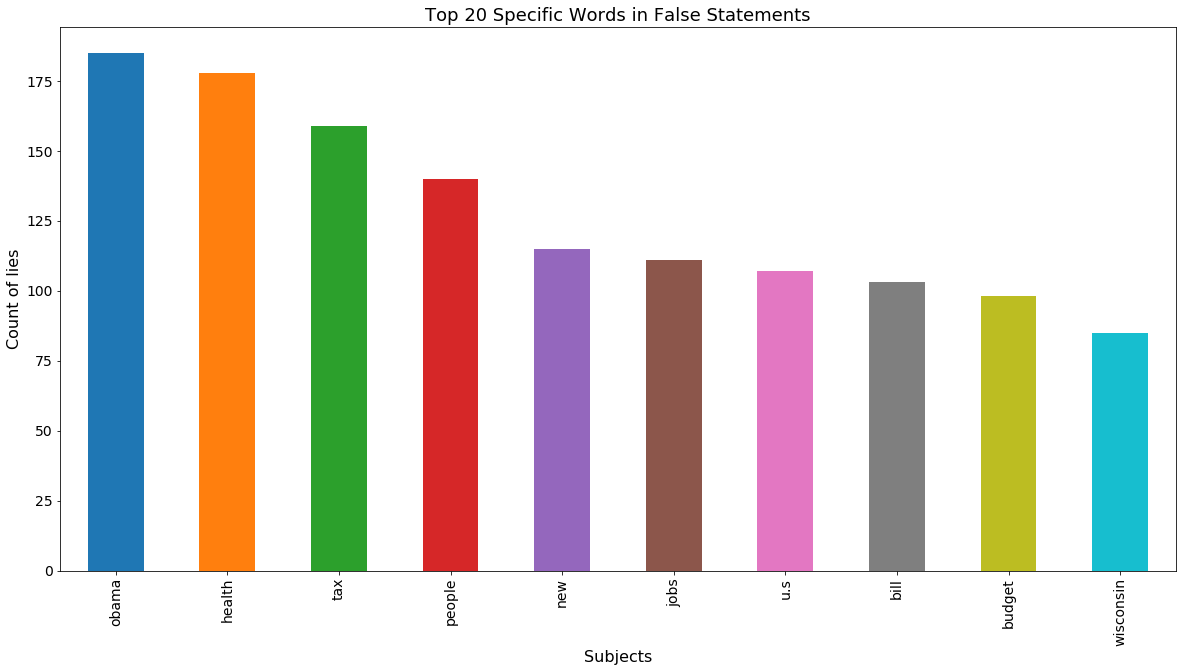

In [49]:
plt.figure(figsize=(20,10))
false_st_count[false_st_count.index.isin(false_words)].plot.bar()
plt.xlabel('Subjects', fontsize=16)
plt.ylabel('Count of lies', fontsize=16)
plt.title('Top 20 Specific Words in False Statements', fontsize=18)
plt.xlabel('Subjects', )
plt.gca().yaxis.set_tick_params(labelsize=14)
plt.gca().xaxis.set_tick_params(labelsize=14)
plt.savefig('Figure2.png', bbox_inches="tight", dpi=200)

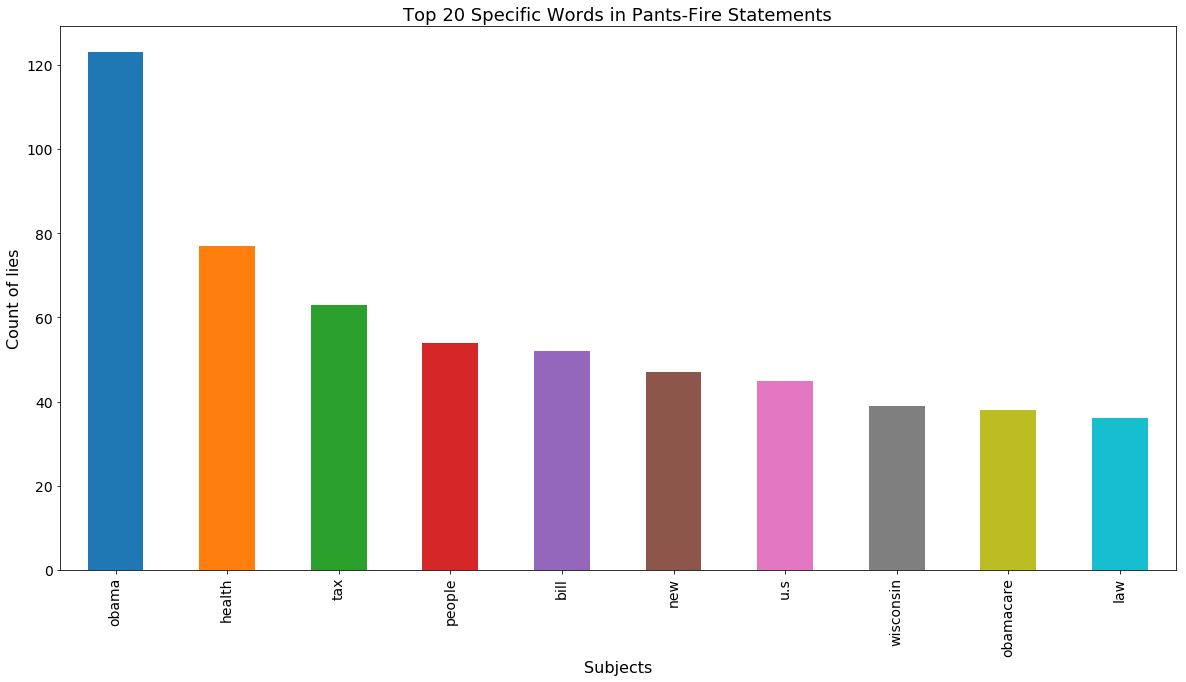

In [50]:
plt.figure(figsize=(20,10))
pants_fire_st_count[pants_fire_st_count.index.isin(pants_fire_words)].plot.bar()
plt.xlabel('Subjects', fontsize=16)
plt.ylabel('Count of lies', fontsize=16)
plt.title('Top 20 Specific Words in Pants-Fire Statements', fontsize=18)
plt.gca().yaxis.set_tick_params(labelsize=14)
plt.gca().xaxis.set_tick_params(labelsize=14)
plt.savefig('Figure2.png', bbox_inches="tight", dpi=200)

We observe that the Former U.S. President Barack Obama's name are the most common word in false and pants-fire statements. Also health-care and tax are very common words in lies. One of the interesting things in this dataset is that the word count of *Wisconsin* in lies is substantial. We can deduce that there are a lot of lies specifically told in Wisconsin or about Wisconsin. Finally, we can see that *Obamacare* is among the most common words in lies list. We think that people against this health reform told considerable amount of lies about this subject.  

### Q3. What are the most frequent words that used in lies relating to specific subjects ?

In [1]:
def make_word_series(df, col_filter, col_parse, string):
    df_col = df[df[col_filter].str.contains(string, na=False)][col_parse]
    word_series = pd.Series(str(v).split(' ') for v in df_col)
    word_series = pd.Series([st for row in word_series for st in row])
    word_series = word_series.str.lower().str.rstrip('.,"”\'').str.lstrip('\'\"”')
    word_series = word_series[~word_series.isin(stopWords)][~word_series.isin([''])]
    return word_series

In [15]:
lies_df = pd.concat([liar_dataframe[liar_dataframe.Label == 'false'], liar_dataframe[liar_dataframe.Label == 'pants-fire']])
truth_df = pd.concat([liar_dataframe[liar_dataframe.Label == 'true'], liar_dataframe[liar_dataframe.Label == 'mostly-true']])

#### Health-care: 

In [18]:
health_care_lies = make_word_series(lies_df, 'Subject', 'Statement', 'health-care')
health_care_lie_counts = health_care_lies.value_counts()
health_care_lie_counts.head()

health       230
care         201
says         102
obamacare     87
law           62
dtype: int64

In [19]:
health_care_truth = make_word_series(truth_df, 'Subject', 'Statement', 'health-care')
health_care_truth_counts = health_care_truth.value_counts()
health_care_truth_counts.head()

health       183
care         135
insurance     69
says          61
percent       49
dtype: int64

Text(0.5,1,'Top 10 Frequent Words Used in Lies Relating to Health-Care')

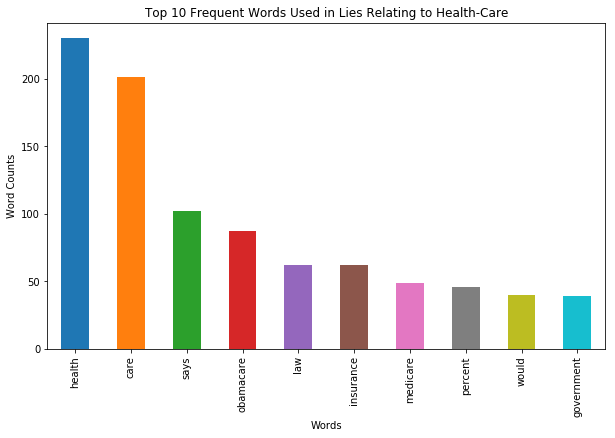

In [20]:
plt.figure(figsize=(10,6))
health_care_lie_counts[0:10].plot.bar()
plt.xlabel('Words')
plt.ylabel('Word Counts')
plt.title('Top 10 Frequent Words Used in Lies Relating to Health-Care')

Text(0.5,1,'Top 10 Frequent Words Used in Truths Relating to Health-Care')

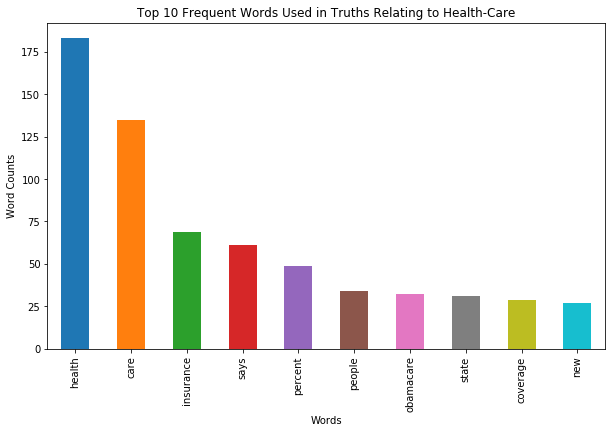

In [21]:
plt.figure(figsize=(10,6))
health_care_truth_counts[0:10].plot.bar()
plt.xlabel('Words')
plt.ylabel('Word Counts')
plt.title('Top 10 Frequent Words Used in Truths Relating to Health-Care')

When top 10 frequent words relating to health-care are analyzed for lies and truths, it is found that some words in lies are not found in top words of truths. These words are 'law', 'medicare', 'would' and 'government'. It is also observed that ranks of some words in lies precede their ranks in truths. These words are 'says' and 'obamacare'.

#### Taxes: 

In [22]:
taxes_lies = make_word_series(lies_df, 'Subject', 'Statement', 'taxes')
taxes_lie_counts = taxes_lies.value_counts()
taxes_lie_counts.head()

tax        184
says        88
taxes       80
percent     37
income      32
dtype: int64

In [23]:
taxes_truth = make_word_series(truth_df, 'Subject', 'Statement', 'taxes')
taxes_truth_counts = taxes_truth.value_counts()
taxes_truth_counts.head()

tax        248
taxes      137
says       100
percent     93
income      53
dtype: int64

Text(0.5,1,'Top 10 Frequent Words Used in Lies Relating to Taxes')

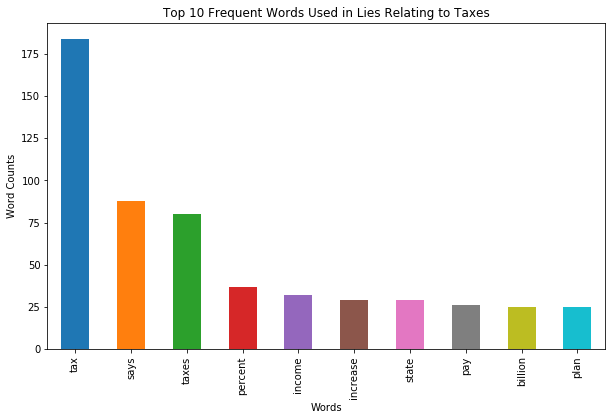

In [24]:
plt.figure(figsize=(10,6))
taxes_lie_counts[0:10].plot.bar()
plt.xlabel('Words')
plt.ylabel('Word Counts')
plt.title('Top 10 Frequent Words Used in Lies Relating to Taxes')

Text(0.5,1,'Top 10 Frequent Words Used in Truth Relating to Taxes')

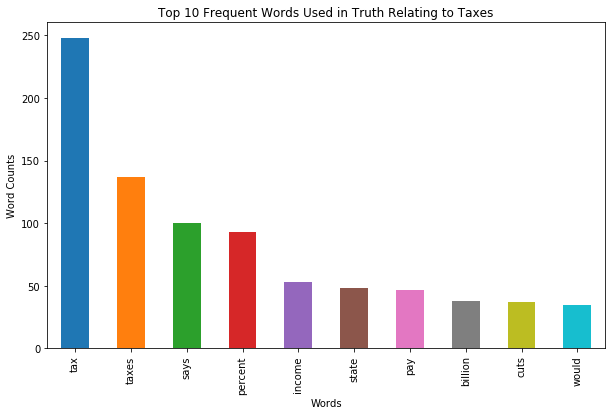

In [25]:
plt.figure(figsize=(10,6))
taxes_truth_counts[0:10].plot.bar()
plt.xlabel('Words')
plt.ylabel('Word Counts')
plt.title('Top 10 Frequent Words Used in Truth Relating to Taxes')

When top 10 frequent words relating to taxes are analyzed for lies and truths, it is found that only one word in lies is not found in top words of truths. It is 'increase'. It is also observed that ranks of no words in lies precedes its rank in truths.

#### Economy:

In [26]:
economy_lies = make_word_series(lies_df, 'Subject', 'Statement', 'economy')
economy_lie_counts = economy_lies.value_counts()
economy_lie_counts.head()

says            50
jobs            50
percent         33
unemployment    29
economy         25
dtype: int64

In [27]:
economy_truth = make_word_series(truth_df, 'Subject', 'Statement', 'economy')
economy_truth_counts = economy_truth.value_counts()
economy_truth_counts.head()

percent    127
jobs       104
says        67
years       53
million     47
dtype: int64

Text(0.5,1,'Top 10 Frequent Words Used in Lies Relating to Economy')

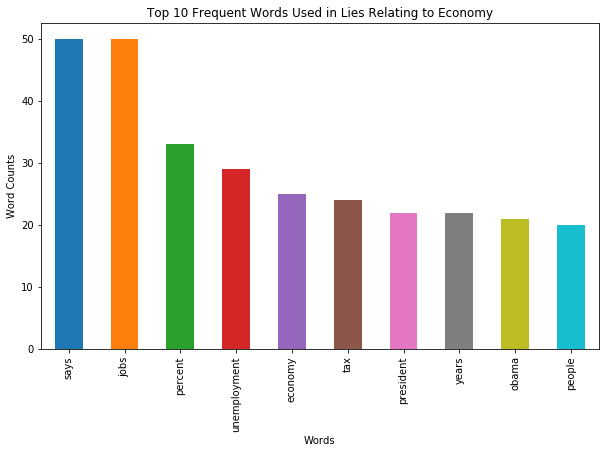

In [28]:
plt.figure(figsize=(10,6))
economy_lie_counts[0:10].plot.bar()
plt.xlabel('Words')
plt.ylabel('Word Counts')
plt.title('Top 10 Frequent Words Used in Lies Relating to Economy')

Text(0.5,1,'Top 10 Frequent Words Used in Truth Relating to Economy')

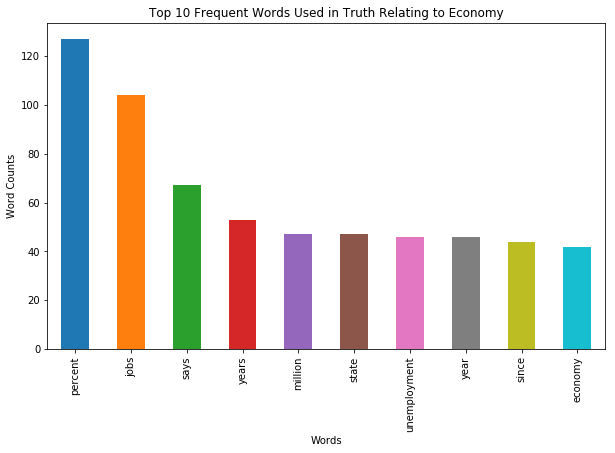

In [29]:
plt.figure(figsize=(10,6))
economy_truth_counts[0:10].plot.bar()
plt.xlabel('Words')
plt.ylabel('Word Counts')
plt.title('Top 10 Frequent Words Used in Truth Relating to Economy')

When top 10 frequent words relating to ecomony are analyzed for lies and truths, it is found that some words in lies are not found in top words of truths. These words are 'tax', 'president', 'obama' and 'people'. It is also observed that ranks of some words in lies precede their rank in truths. These words are 'says', 'economy' and 'unemployment'.

#### Immigration:

In [30]:
immigration_lies = make_word_series(lies_df, 'Subject', 'Statement', 'immigration')
immigration_lie_counts = immigration_lies.value_counts()
immigration_lie_counts.head()

illegal        56
says           50
immigrants     35
immigration    35
border         26
dtype: int64

In [31]:
immigration_truth = make_word_series(truth_df, 'Subject', 'Statement', 'immigration')
immigration_truth_counts = immigration_truth.value_counts()
immigration_truth_counts.head()

says           41
immigration    41
immigrants     35
illegal        35
border         30
dtype: int64

Text(0.5,1,'Top 10 Frequent Words Used in Lies Relating to Immigration')

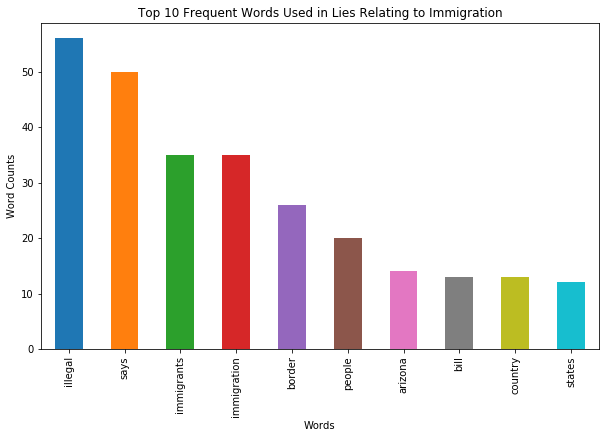

In [33]:
plt.figure(figsize=(10,6))
immigration_lie_counts[0:10].plot.bar()
plt.xlabel('Words')
plt.ylabel('Word Counts')
plt.title('Top 10 Frequent Words Used in Lies Relating to Immigration')

Text(0.5,1,'Top 10 Frequent Words Used in Truth Relating to Immigration')

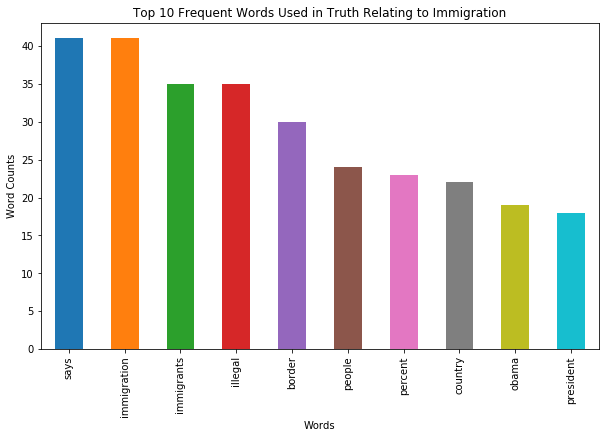

In [32]:
plt.figure(figsize=(10,6))
immigration_truth_counts[0:10].plot.bar()
plt.xlabel('Words')
plt.ylabel('Word Counts')
plt.title('Top 10 Frequent Words Used in Truth Relating to Immigration')

When top 10 frequent words relating to immigration are analyzed for lies and truths, it is found that some words in lies are not found in top words of truths. These words are 'arizona', 'bill', and 'voted'. It is also observed that ranks of some words in lies precede their rank in truths. These words are 'illegal', and 'immigrants.

Overall, it can be deduced that top words in both lies and truths are the words related to the category and therefore expected. Even though there are difference of ranks in top words of lies and truths, this difference is not enough to deduce that a sentence with a given word has a higher chance of being true or a lie.

### Q4. What is the total number of lies told by state representers ?

We will count the number of false and pants-fire statements made in each state. Also, in order to remove places which are not a state of United States, we maintain a list of state names of United States. 

In [15]:
# State names list
import pickle
with open('data/state_names.pkl', 'rb') as f:
    states = pickle.load(f)

First, we get the counts of false and pants-fire statements made in each state. Then, we concat them to create lie counts for each state.

In [19]:
# Get the counts of false and pants-fire statements for each state
state_counts = get_count_group('State', data_group_df, '', True)
false_st_states = state_counts[1][1]
pants_fire_states = state_counts[4][1]

# Concat false and pants-fire statements
lie_states = pd.concat([false_st_states, pants_fire_states])
lie_states = lie_states.groupby(lie_states.index).sum()

# Convert it to a dataframe
lie_states = pd.DataFrame(lie_states)

# Remove state name as an index
lie_states = lie_states.reset_index()

In [20]:
lie_states.head()

,index,0
0,Alabama,7
1,Alaska,34
2,Arizona,60
3,Arkansas,20
4,California,47


In [21]:
# Rename the new columns
lie_states = lie_states.rename({"index":"id", 0: "Lies"}, axis='columns')

In [22]:
# If the place is a state of United States
lie_states = lie_states[lie_states['id'].isin(states)]

In [23]:
# Sort the dataset w.r.t lie counts
lie_states = lie_states.sort_values(by=['Lies'], ascending=False)

# Make state name index
lie_states.set_index('id', inplace=True)

In [24]:
lie_states.head()

,Lies
id,
Texas,333
Wisconsin,291
Florida,273
New York,272
Virginia,147


We can see that the top 5 state which have the largest number of lie statements are Texas, Wisconsin, Florida, New York and Virginia. We can deduce that since Texas and New York are among the largest states of United States, the number of false and pants-fire statements made in these states are high unsurprisingly. However, although Wisconsin is a small state, it has a huge number of lies interestingly. We show the number of lies told in each state in a bar chart below.

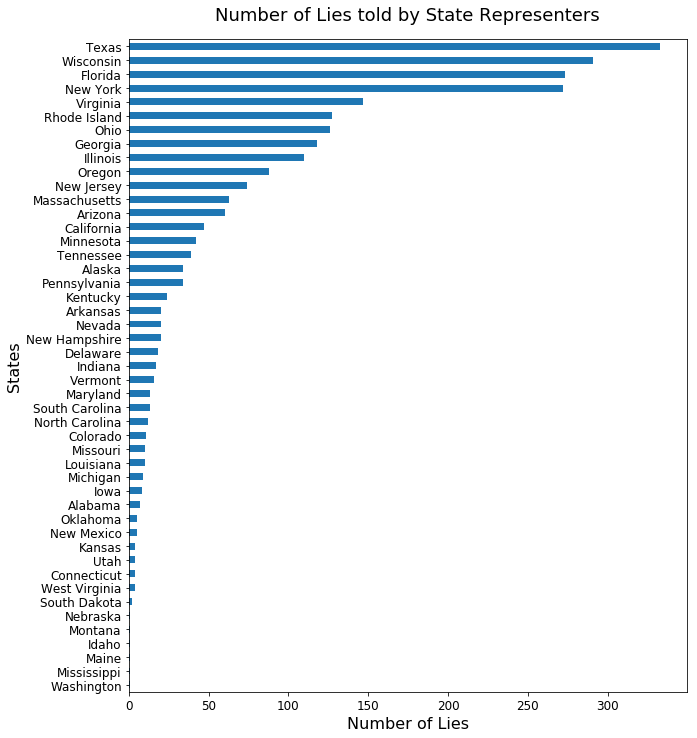

In [29]:
# Show the bar chart
lie_states.sort_values(by=['Lies'], ascending=True).plot.barh(legend=None, figsize=(10,12))
plt.ylabel('States', fontsize=16)
plt.xlabel('Number of Lies', fontsize=16)
plt.title('Number of Lies told by State Representers', y=1.02, fontsize=18)
plt.gca().yaxis.set_tick_params(labelsize=12)
plt.gca().xaxis.set_tick_params(labelsize=12)
plt.savefig('Figure4.png', bbox_inches="tight", dpi=200)

Also we show the number of false and pants-fire statements made in each state in a `Folium` map. 

In [643]:
# Get the GeoJson File
geo_json = json.load(open('data/us-states.json'))

# Convert indices to column for folium
lie_states = lie_states.reset_index()

us_map = folium.Map(location=[40, -102], zoom_start=4)

us_map.choropleth(geo_data=geo_json, 
                  data=lie_states,
                  columns=['id', 'Lies'],
                  key_on='feature.properties.name',
                  fill_color='YlGn',
                  fill_opacity=0.7,
                  line_opacity=0.2,
                  legend_name='Number of Lies'
                 )

us_map.save('static/map.html')

In [695]:
from IPython.display import HTML
HTML('<iframe src=static/map.html width=800 height=500></iframe>')

### Q5. Do republicans and democrats tell lies more in the states that they won or they lost ?

In [656]:
# Dictionary from State Name to State Code like CA, AL etc.
with open("data/us_abbrev.pkl", "rb") as input_file:
    US_state_to_code = pickle.load(input_file)

In [657]:
US_state_to_code['Florida ']='FL'

In [658]:
# get count of a given column per each label category
# Data having dates between min_date and max_date filtered
# Political View: Democrat - Republican can also be filtered by 'party' parameter

def get_count_group_by_years(min_date,max_date,col_num, df, delimiter, get_all, party,n=0):
    result = []
    i = 0
    for group in df:
        group[1]['Date'] = pd.to_datetime(group[1]['Date'])
        col = group[1].loc[np.logical_and(group[1]['Date']>min_date , group[1]['Date']<max_date)]
        col = col.loc[col['The Party Affiliation']==party]
        col = col[col_num]
        if(len(delimiter) > 0):
            if(get_all):
                elements = pd.Series(str(v).split(delimiter) for v in col)
            else:
                elements = pd.Series(str(v).split(delimiter) for v in col)
            elements = [st for row in elements for st in row]
            element_values = pd.Series(elements).str.lower().str.rstrip('.,"”\'').str.lstrip('\'\"”').value_counts()
        else:
            elements = pd.Series(v for v in col)
            elements = [st for st in elements]
            element_values = pd.Series(elements).value_counts()
        result.append([])
        result[i].append(group[0])
        result[i].append(element_values)
        i = i + 1
    return result

Dataset is grouped according to its truth label.

In [659]:
# grouping all statements data by label
data_group_df = liar_dataframe.groupby('Label')

Official Dates of US Elections are assigned to variables **date_year**_election.

In [660]:
date_2008_election = datetime(2008, 11, 4, 0, 0)
date_2012_election = datetime(2012, 11, 6, 0, 0)
date_2016_election = datetime(2016, 11, 8, 0, 0)

state\_counts\_"year"_"politicView" = number of statements grouped by states where (democrat or republican)speakers given their speeches between last election and the election in "year" grouped by the truth labels.

For instance: For state_counts_2012_democrat, data samples between 'date_2008_election' and 'date_2012_election' and said by a democrat are filtered. 

In [661]:
#count of states where (democrat or republican)speakers said their statements grouped by the truth labels 2012 
state_counts_2012_democrat = get_count_group_by_years(date_2008_election,date_2012_election,'State',\
                                                 data_group_df, '', True,'democrat')
state_counts_2012_republican = get_count_group_by_years(date_2008_election,date_2012_election,'State',\
                                                 data_group_df, '', True,'republican')

#count of states where (democrat or republican)speakers said their statements grouped by the truth labels 2016
state_counts_2016_democrat = get_count_group_by_years(date_2012_election,date_2016_election,'State',\
                                                 data_group_df, '', True,'democrat')
state_counts_2016_republican = get_count_group_by_years(date_2012_election,date_2016_election,'State',\
                                                 data_group_df, '', True,'republican')

/Users/canaltinigne/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [662]:
print('Label:',state_counts_2012_democrat[0][0])
print('State Counts:\n',state_counts_2012_democrat[0][1])

Label: barely-true
State Counts:
 Illinois            38
Florida             33
Texas               29
Wisconsin           24
Rhode Island        16
Virginia            12
New Jersey          12
Ohio                11
Oregon              10
Georgia              9
New Hampshire        7
California           4
Massachusetts        4
Delaware             4
New York             4
Arkansas             3
Nevada               3
Pennsylvania         2
Tennessee            1
Washington, D.C.     1
Louisiana            1
South Carolina       1
Indiana              1
dtype: int64


#### Calculation of Number of Lies Said in Each State<br>

We determined the number of lies said by democrats or republicans starting from the last election until the current election. (For 2012: 2008 - 2012)<br>
We converted the state names to state codes, since the election results have state column as state code.

In [663]:
#2012 election - Democrat
# Number of "pants fire" and "false" statements said in each state are summed. 
lie_count_2012_democrat = state_counts_2012_democrat[1][1].add(state_counts_2012_democrat[4][1], fill_value=0)
#set state codes as index
lie_count_2012_democrat.index=[US_state_to_code[state] for state in lie_count_2012_democrat.index]

#2012 election - Republican
# Number of "pants fire" and "false" statements said in each state are summed. 
lie_count_2012_republican = state_counts_2012_republican[1][1].add(state_counts_2012_republican[4][1], fill_value=0)
#set state codes as index
lie_count_2012_republican.index=[US_state_to_code[state] for state in lie_count_2012_republican.index]

#same process for 2016 presidental election
lie_count_2016_democrat = state_counts_2016_democrat[1][1].add(state_counts_2016_democrat[4][1], fill_value=0)
lie_count_2016_democrat.index=[US_state_to_code[state] for state in lie_count_2016_democrat.index]
lie_count_2016_republican = state_counts_2016_republican[1][1].add(state_counts_2016_republican[4][1], fill_value=0)
lie_count_2016_republican.index=[US_state_to_code[state] for state in lie_count_2016_republican.index]

In [664]:
print("Lies said by democrats starting from 2012 until 2016 election:\n",lie_count_2016_democrat.head())

Lies said by democrats starting from 2012 until 2016 election:
 AK     1.0
AR     1.0
CA    11.0
DE     3.0
FL    34.0
dtype: float64


#### Number of lies in states where the republicans won and lost. (2012-2016)
We calculated the number of lies said by democrats and republicans in the states where they won and lost in 2012 and 2016.
In these dataframes, indices are the US State Codes and the only column is 'Lie Count'.
State column is set as the index of the dataframes so that the lie counts calculated in the previous step can be assigned to each each state won or lost by democrats or republicans.  

In [665]:
# initialize dataframes for states won by democrats and republicans
won_states_democrat_2012=pd.DataFrame()
lost_states_democrat_2012=pd.DataFrame()
won_states_republican_2012=pd.DataFrame()
lost_states_republican_2012=pd.DataFrame()

# Number of lies said by democrats in the states where they won the election in 2012.
won_states_democrat_2012['STATE'] = votes_2012.loc[votes_2012['Winner'] == 'D']['STATE']
won_states_democrat_2012 = won_states_democrat_2012.set_index('STATE')
lie_count_2012_democrat = lie_count_2012_democrat[~lie_count_2012_democrat.index.duplicated()]
won_states_democrat_2012['Lie Count'] = lie_count_2012_democrat.to_frame()[0]
won_states_democrat_2012 = won_states_democrat_2012.fillna(0)

# Number of lies said by democrats in the states where they lost the election in 2012.
lost_states_democrat_2012['STATE'] = votes_2012.loc[votes_2012['Winner'] == 'R']['STATE']
lost_states_democrat_2012 = lost_states_democrat_2012.set_index('STATE')
lost_states_democrat_2012['Lie Count'] = lie_count_2012_democrat.to_frame()[0]
lost_states_democrat_2012 = lost_states_democrat_2012.fillna(0)

# Number of lies said by republicans in the states where they won the election in 2012.
won_states_republican_2012['STATE'] = votes_2012.loc[votes_2012['Winner'] == 'R']['STATE']
won_states_republican_2012 = won_states_republican_2012.set_index('STATE')
lie_count_2012_republican = lie_count_2012_republican[~lie_count_2012_republican.index.duplicated()]
won_states_republican_2012['Lie Count'] = lie_count_2012_republican.to_frame()[0]
won_states_republican_2012 = won_states_republican_2012.fillna(0)

# Number of lies said by republicans in the states where they lost the election in 2012.
lost_states_republican_2012['STATE'] = votes_2012.loc[votes_2012['Winner'] == 'D']['STATE']
lost_states_republican_2012 = lost_states_republican_2012.set_index('STATE')
lost_states_republican_2012['Lie Count'] = lie_count_2012_republican.to_frame()[0]
lost_states_republican_2012 = lost_states_republican_2012.fillna(0)

In [666]:
lost_states_republican_2012.head()

,Lie Count
STATE,
CA,10.0
CO,1.0
CT,1.0
DE,2.0
DC,1.0


In [667]:
# initialize dataframes for states won by democrats and republicans
won_states_democrat_2016=pd.DataFrame()
lost_states_democrat_2016=pd.DataFrame()
won_states_republican_2016=pd.DataFrame()
lost_states_republican_2016=pd.DataFrame()

# Number of lies said by democrats in the states where they won the election in 2016.
won_states_democrat_2016['STATE'] = votes_2016.loc[votes_2016['Winner'] == 'D']['STATE']
won_states_democrat_2016 = won_states_democrat_2016.set_index('STATE')
lie_count_2016_democrat = lie_count_2016_democrat[~lie_count_2016_democrat.index.duplicated()]
won_states_democrat_2016['Lie Count'] = lie_count_2016_democrat.to_frame()[0]
won_states_democrat_2016 = won_states_democrat_2016.fillna(0)

# Number of lies said by democrats in the states where they lost the election in 2016.
lost_states_democrat_2016['STATE'] = votes_2016.loc[votes_2016['Winner'] == 'R']['STATE']
lost_states_democrat_2016 = lost_states_democrat_2016.set_index('STATE')
lost_states_democrat_2016['Lie Count'] = lie_count_2016_democrat.to_frame()[0]
lost_states_democrat_2016 = lost_states_democrat_2016.fillna(0)

# Number of lies said by republicans in the states where they won the election in 2016.
won_states_republican_2016['STATE'] = votes_2016.loc[votes_2016['Winner'] == 'R']['STATE']
won_states_republican_2016 = won_states_republican_2016.set_index('STATE')
lie_count_2016_republican = lie_count_2016_republican[~lie_count_2016_republican.index.duplicated()]
won_states_republican_2016['Lie Count'] = lie_count_2016_republican.to_frame()[0]
won_states_republican_2016 = won_states_republican_2016.fillna(0)

# Number of lies said by republicans in the states where they lost the election in 2016.
lost_states_republican_2016['STATE'] = votes_2016.loc[votes_2016['Winner'] == 'D']['STATE']
lost_states_republican_2016 = lost_states_republican_2016.set_index('STATE')
lost_states_republican_2016['Lie Count'] = lie_count_2016_republican.to_frame()[0]
lost_states_republican_2016 = lost_states_republican_2016.fillna(0)

In [668]:
won_states_republican_2016.head()

,Lie Count
STATE,
AL,2.0
AK,10.0
AZ,2.0
AR,7.0
FL,62.0


We compare the means of lies in the states that Republicans and Democrats win and the states that they lose in 2012 and 2016 elections in order to determine in which type of states that they lie more. Since the standard deviation of the lie samples for both type of states have unequal variances and unequal sample sizes, we decide to use Welch's T-Test to compare means of the samples. We select the significance level as 0.05.

* ### Welch's T-Test between Lies said by Democrats in Won and Lost states 2012

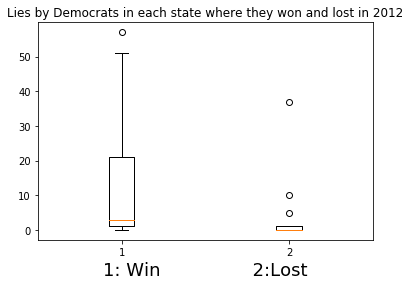

In [669]:
fig, ax = plt.subplots()
ax.set_title('Lies by Democrats in each state where they won and lost in 2012')
ax.boxplot([won_states_democrat_2012['Lie Count'],lost_states_democrat_2012['Lie Count']])
plt.xlabel('1: Win                2:Lost', fontsize=18)
plt.show()

In [670]:
won_states_democrat_2012['Lie Count'].describe()

count    27.000000
mean     12.259259
std      17.603742
min       0.000000
25%       1.000000
50%       3.000000
75%      21.000000
max      57.000000
Name: Lie Count, dtype: float64

In [671]:
lost_states_democrat_2012['Lie Count'].describe()

count    24.000000
mean      2.375000
std       7.699873
min       0.000000
25%       0.000000
50%       0.000000
75%       1.000000
max      37.000000
Name: Lie Count, dtype: float64

In [674]:
stats.ttest_ind(won_states_democrat_2012['Lie Count'], lost_states_democrat_2012['Lie Count'], equal_var = False)

Ttest_indResult(statistic=2.6466174086831313, pvalue=0.011927574727831309)

p-value is below significance level of 0.05. It means that the mean of the lie counts is significantly higher in states that Democrats win than the states that they lose in 2012 elections. We consider the lies before 2012 elections.

* ### Welch's T-Test between Lies said by Democrats in Won and Lost states 2016

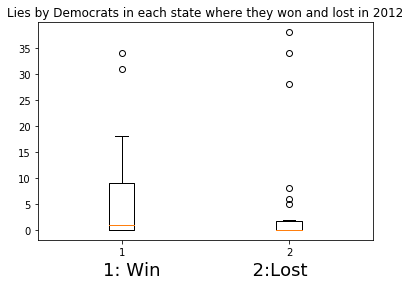

In [675]:
fig, ax = plt.subplots()
ax.set_title('Lies by Democrats in each state where they won and lost in 2012')
ax.boxplot([won_states_democrat_2016['Lie Count'],lost_states_democrat_2016['Lie Count']])
plt.xlabel('1: Win                2:Lost', fontsize=18)
plt.show()

In [676]:
won_states_democrat_2016['Lie Count'].describe()

count    21.000000
mean      6.428571
std      10.146780
min       0.000000
25%       0.000000
50%       1.000000
75%       9.000000
max      34.000000
Name: Lie Count, dtype: float64

In [678]:
lost_states_democrat_2016['Lie Count'].describe()

count    30.000000
mean      4.300000
std      10.117073
min       0.000000
25%       0.000000
50%       0.000000
75%       1.750000
max      38.000000
Name: Lie Count, dtype: float64

In [679]:
stats.ttest_ind(won_states_democrat_2016['Lie Count'], lost_states_democrat_2016['Lie Count'], equal_var = False)

Ttest_indResult(statistic=0.738190731744156, pvalue=0.4643973785354718)

p-value is above significance level of 0.05. It means that we can not reject the null hypothesis which state that there is no significant difference between the means of counts sample in Democrats' win states and lost states in 2016 elections.

### Welch's T-Test between Lies said by Republican in Won and Lost states 2012

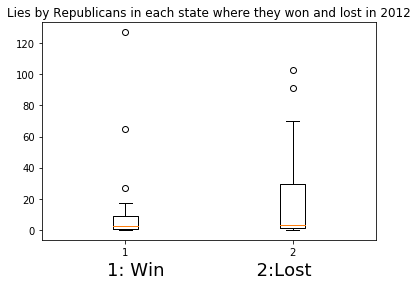

In [686]:
fig, ax = plt.subplots()
ax.set_title('Lies by Republicans in each state where they won and lost in 2012')
ax.boxplot([won_states_republican_2012['Lie Count'],lost_states_republican_2012['Lie Count']])
plt.xlabel('1: Win                2:Lost', fontsize=18)
plt.show()

In [681]:
won_states_republican_2012['Lie Count'].describe()

count     24.000000
mean      12.500000
std       28.119311
min        0.000000
25%        0.750000
50%        2.500000
75%        9.250000
max      127.000000
Name: Lie Count, dtype: float64

In [682]:
lost_states_republican_2012['Lie Count'].describe()

count     27.000000
mean      19.666667
std       28.772316
min        0.000000
25%        1.000000
50%        3.000000
75%       29.500000
max      103.000000
Name: Lie Count, dtype: float64

In [683]:
stats.ttest_ind(won_states_republican_2012['Lie Count'], lost_states_republican_2012['Lie Count'], equal_var = False)

Ttest_indResult(statistic=-0.8985992323793024, pvalue=0.37330218086657174)

p-value is above significance level of 0.05. It means that we can not reject the null hypothesis which state that there is no significant difference between the means of counts sample in Republicans' win states and lost states in 2012 elections.

### Welch's T-Test between Lies said by Republican in Won and Lost states 2016

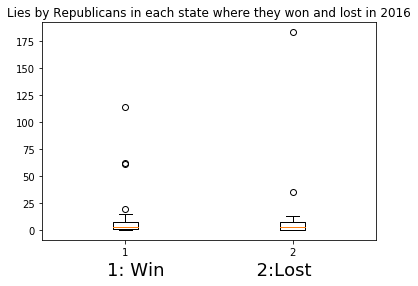

In [685]:
fig, ax = plt.subplots()
ax.set_title('Lies by Republicans in each state where they won and lost in 2016')
ax.boxplot([won_states_republican_2016['Lie Count'],lost_states_republican_2016['Lie Count']])
plt.xlabel('1: Win                2:Lost', fontsize=18)
plt.show()

In [687]:
won_states_republican_2016['Lie Count'].describe()

count     30.000000
mean      11.733333
std       24.622576
min        0.000000
25%        1.000000
50%        3.000000
75%        7.750000
max      114.000000
Name: Lie Count, dtype: float64

In [688]:
lost_states_republican_2016['Lie Count'].describe()

count     21.000000
mean      13.857143
std       39.538950
min        0.000000
25%        0.000000
50%        3.000000
75%        7.000000
max      183.000000
Name: Lie Count, dtype: float64

In [692]:
stats.ttest_ind(won_states_republican_2016['Lie Count'], lost_states_republican_2016['Lie Count'], equal_var = False)

Ttest_indResult(statistic=-0.21829700445116615, pvalue=0.8286391234541339)

p-value is above significance level of 0.05. It means that we can not reject the null hypothesis which state that there is no significant difference between the means of counts sample in Republicans' win states and lost states in 2016 elections.

### Q6. Visualization of the truth ratios of the statements made by famous politicians

We consider that a statement is a lie if it is labelled as false or pants-fire. We create the counts of subjects for each label category.

In [16]:
speakers = get_count_group('Speaker’s Job Title', data_group_df, ' ', True)
notable_people = ['barack-obama', 'donald-trump', 'hillary-clinton']

In [17]:
from collections import defaultdict

lst = []
column_name = []

column_set=False

for person in notable_people:
    pe_list = []
    for i in range(6):
        pe_list.append(speakers[i][1][person])
        
        if not column_set:
            column_name.append(speakers[i][0])
        
    column_set = True
        
    lst.append(pe_list)
        
speaker_df = pd.DataFrame(lst)

speaker_df.index = ['Barack Obama', 'Donald Trump', 'Hillary Clinton']
speaker_df.columns = column_name
speaker_df = speaker_df[['pants-fire', 'false', 'barely-true', 'half-true', 'mostly-true',  'true']]
speaker_df['pants-fire'] += speaker_df['false'] 
speaker_df.drop(columns=['false'], inplace=True)
speaker_df.rename(columns={"pants-fire": "lie"} , inplace=True)

In [18]:
speaker_df

,lie,barely-true,half-true,mostly-true,true
Barack Obama,90,70,165,163,123
Donald Trump,178,63,51,37,14
Hillary Clinton,39,40,69,76,73


[14.7299509  11.45662848 27.00490998 26.67757774 20.1309329  14.7299509 ]
[51.89504373 18.36734694 14.86880466 10.78717201  4.08163265 51.89504373]
[13.13131313 13.46801347 23.23232323 25.58922559 24.57912458 13.13131313]


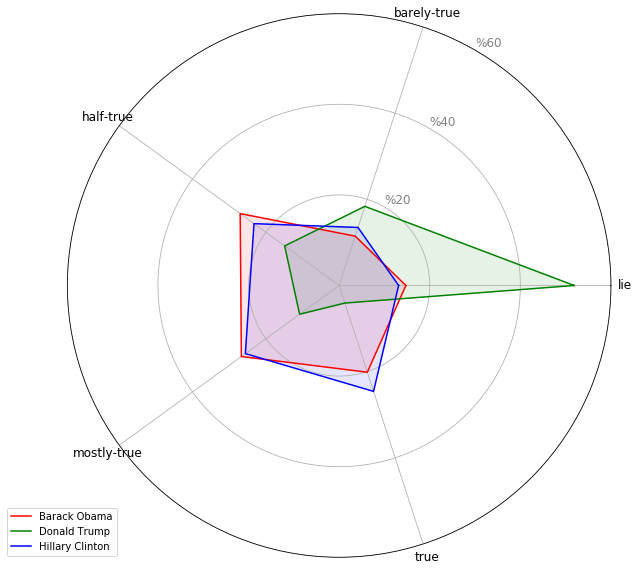

In [32]:
from math import pi
 
N = 5
categories = list(speaker_df.columns)

angles = [n / float(N) * 2 * pi for n in range(N)]
angles.append(angles[0])
 
plt.figure(figsize=(10,10))
ax = plt.subplot(111, polar=True)
plt.xticks(angles[:-1], categories, size=12)
 
ax.set_rlabel_position(60)
plt.yticks([20,40,60], ["%20","%40","%60"], color="grey", size=12)
plt.ylim(0,60)
cl = dict(zip(list(speaker_df.index), ['r', 'g', 'b']))
    
for name in list(speaker_df.index):
    values = np.array(list(speaker_df.loc[name]))
    values = np.divide(values, sum(values))
    values *= 100
    values = np.append(values, values[0])
    print(values)
    ax.plot(angles, values, linewidth=1.5, linestyle='solid', label=name, color=cl[name])
    ax.fill(angles, values, cl[name], alpha=0.1)
    
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

### Q7. Trump's False Statements during 2016 Elections Campaign

In [375]:
trump_lies = liar_dataframe[(liar_dataframe.iloc[:,4] == 'donald-trump') & 
                            ((liar_dataframe['Label'] == 'false') | 
                             (liar_dataframe['Label'] == 'pants-fire'))].copy()

In [390]:
trump_lies['Date'] = pd.to_datetime(trump_lies['Date'], format='%Y%m%d')
trump_lies = trump_lies[(trump_lies['Date'] > "2015-06-15") & (trump_lies['Date'] < "2016-11-08")]
lies = trump_lies[['Id', 'Date']].groupby(pd.Grouper(key='Date', freq='6W')).count()
lies = lies.reset_index()
lies = lies.drop(13)

In [392]:
lies = lies.set_index('Date')
#lies.index = pd.to_datetime(lies.index.strftime('%Y %m %d'))

In [393]:
lies.index

DatetimeIndex(['2015-06-21', '2015-08-02', '2015-09-13', '2015-10-25',
               '2015-12-06', '2016-01-17', '2016-02-28', '2016-04-10',
               '2016-05-22', '2016-07-03', '2016-08-14', '2016-09-25',
               '2016-11-06'],
              dtype='datetime64[ns]', name='Date', freq=None)

Text(0.5,1,'Trump Lies during 2016 Elections Campaign')

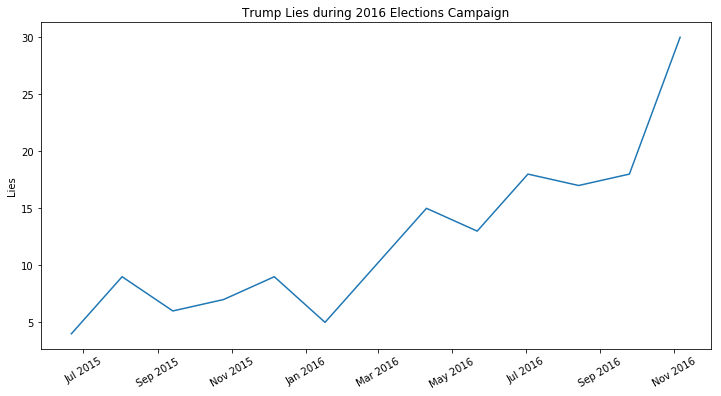

In [409]:
import matplotlib.dates as mdates

plt.figure(figsize=(12,6))
plt.plot(lies.index, lies['Id'])
plt.ylabel('Lies')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
plt.xticks(rotation=30)

## Rotate date labels automatically
plt.title('Trump Lies during 2016 Elections Campaign')

In [411]:
lies = lies.reset_index()
lies['Date'] = lies['Date'].astype(int)

In [412]:
from scipy.stats import spearmanr

corr, p_val = spearmanr(lies)
print("Spearman Rank Correlation Test\nCorrelation: {} - p-value: {}".format(corr, p_val))

Spearman Rank Correlation Test
Correlation: 0.9063395272835296 - p-value: 1.9576561673536152e-05


In [413]:
from scipy.stats import pearsonr

corr, p_val = pearsonr(lies['Date'], lies['Id'])
print("Pearson Correlation Test\nCorrelation: {} - p-value: {}".format(corr, p_val))

Pearson Correlation Test
Correlation: 0.8775851873460432 - p-value: 8.062258485416106e-05


### Q8. Quarrel Network

In [12]:
lies = liar_dataframe[((liar_dataframe['Label'] == 'false') | 
                             (liar_dataframe['Label'] == 'pants-fire'))].copy()

In [13]:
lies.shape

(3555, 16)

In [14]:
not_included = ['chain-email', 'blog-posting', 'facebook-posts', 'viral-image', 
                'national-republican-congressional-committee', 'democratic-congressional-campaign-committee',
               'state-democratic-party-wisconsin', 'republican-party-florida', 
                'national-republican-senatorial-committee']

In [21]:
top50 = list(lies.groupby('Speaker’s Job Title').count().sort_values(by=['Id'], ascending=False).iloc[:20,:].index)
selected_people = [x for x in top50 if x not in not_included]

In [22]:
len(selected_people)

17

In [23]:
selected_people

['donald-trump',
 'barack-obama',
 'scott-walker',
 'mitt-romney',
 'rick-perry',
 'john-mccain',
 'ted-cruz',
 'hillary-clinton',
 'michele-bachmann',
 'rick-scott',
 'marco-rubio',
 'newt-gingrich',
 'sarah-palin',
 'chris-christie',
 'john-boehner',
 'rick-santorum',
 'rush-limbaugh']

In [24]:
searched_people = []

for person in selected_people:
    searched_people.append(person.replace("-", " ").split()[-1])
    
searched_people

['trump',
 'obama',
 'walker',
 'romney',
 'perry',
 'mccain',
 'cruz',
 'clinton',
 'bachmann',
 'scott',
 'rubio',
 'gingrich',
 'palin',
 'christie',
 'boehner',
 'santorum',
 'limbaugh']

In [25]:
quarrel = [[0 for x in range(len(selected_people))] for y in range(len(selected_people))]

for i in range(len(selected_people)): 
    statements = list(lies[lies['Speaker’s Job Title'] == selected_people[i]]['Statement'])

    for statement in statements:
        for j in range(len(selected_people)):
            if i != j:
                if searched_people[j] in statement.lower().strip().split():
                    quarrel[i][j] += 1

In [26]:
np.sum(quarrel, axis=1)

array([42, 14,  3, 15,  5, 20, 13,  9,  5,  1,  5,  5,  4,  1,  3,  6,  5])

In [140]:
edges = []

for i in range(len(quarrel)):
    for j in range(len(quarrel)):
        if quarrel[i][j] != 0:
            edges.append({'from': i+1, 'to': j+1, 'weight': quarrel[i][j]})

In [146]:
import json

with open('edges.json', 'w') as f:
    f.write(json.dumps(edges))

In [3]:
from IPython.display import HTML
HTML('<iframe src=network_deneme.html width=800 height=800></iframe>')

**Images:**

- _"Scott Walker speaking at the 2017 CPAC in National Harbor, Maryland." by Greg Skidmore is licensed under CC BY-SA 3.0_

- _Other images are in public domain and taken from Wikimedia Commons._